## <small>
Copyright (c) 2017-21 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning: A Visual Approach
## by Andrew Glassner, https://glassner.com
### Order: https://nostarch.com/deep-learning-visual-approach
### GitHub: https://github.com/blueberrymusic
------

### What's in this notebook

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is cleaned up a bit from the original code that I hacked together, and is only lightly commented. I wrote the code to be easy to interpret and understand, even for those who are new to Python. I tried never to be clever or even more efficient at the cost of being harder to understand. The code is in Python3, using the versions of libraries as of April 2021. 

This notebook may contain additional code to create models and images not in the book. That material is included here to demonstrate additional techniques.

Note that I've included the output cells in this saved notebook, but Jupyter doesn't save the variables or data that were used to generate them. To recreate any cell's output, evaluate all the cells from the start up to that cell. A convenient way to experiment is to first choose "Restart & Run All" from the Kernel menu, so that everything's been defined and is up to date. Then you can experiment using the variables, data, functions, and other stuff defined in this notebook.

## Chapter 17: Convnets in Practice - Notebook 3: Filter Visualization 1

This code is adapted from https://github.com/fchollet/deep-learning-with-python-notebooks

In [1]:
import keras
import tensorflow as tf
from keras.applications import VGG16
# from tensorflow.python.keras import backend as k_backend
# from tensorflow.keras._tf_keras.keras import backend as k_backend
from keras import backend as K_backend
import numpy as np
import math
import matplotlib.pyplot as plt

# Disable eager execution constraint form tf2 with the compat mode for tf1
# tf.compat.v1.disable_eager_execution()

# Just in case the Keras defaults aren't as we expect
K_backend.set_image_data_format('channels_last')

In [2]:
# Workaround for Keras issues on Mac computers (you can comment this
# out if you're not on a Mac, or not having problems)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
# Make a File_Helper for saving and loading files.

save_files = False

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

In [4]:
def get_VGG16():
    model = VGG16(weights='imagenet', include_top=False)
    return model

In [11]:
def prepare_image_for_display(image):
    # normalize tensor: center on 0., ensure std is 0.1
    image -= image.mean()
    image /= (image.std() + 1e-5)
    image *= 0.1
    image += 0.5

    # convert to RGB array
    image *= 255
    image = np.clip(image, 0, 255).astype('uint8')
    return image

In [12]:
# This is where the Keras magic happens.
# From https://github.com/fchollet/deep-learning-with-python-notebooks
def get_filter_image(model, layer_name, filter_index, size=150, num_steps=40):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered. We find the
    # average value of all the activations coming out of the filter.
    layer_output = model.get_layer(layer_name).output
    print('layer_output', layer_output)
    
    model_input = model.input
    print('model_input', model_input)
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    input_tensor = tf.convert_to_tensor(input_img_data)

    # Run gradient ascent 
    layer_model = keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    step_size = 1.
    for i in range(num_steps):
        with tf.GradientTape() as g:
            g.watch(input_tensor)
            layer_output_tensor = layer_model(input_tensor)
            goal = keras.ops.mean(layer_output_tensor[:, :, :, filter_index])
            print('loss', goal)
            grads = g.gradient(goal, input_tensor)
            # Normalization trick: we normalize the gradient
            grads /= (keras.ops.sqrt(keras.ops.mean(keras.ops.square(grads))) + 1e-5)
            input_tensor += grads * step_size
    
    img = input_tensor.numpy()[0]
    return prepare_image_for_display(img)

In [13]:
def show_one_filter(model, layer_name, filter_number, size=150, filename=None):
    filter_image = get_filter_image(model, layer_name, filter_number, size)
    plt.imshow(filter_image)
    plt.xticks([],[])
    plt.yticks([],[])
    plt.title(layer_name)
    file_helper.save_figure(filename)
    plt.show()

In [14]:
# Show a bunch of filters from the given layer
def show_filter_grid(model, layer_name, filters_list, num_rows, num_cols, filename=None):
    img_size = 64
    gap_size = 3
    
    pixels_wide = (num_cols * img_size) + ((num_cols-1) * gap_size)
    pixels_high = (num_rows * img_size) + ((num_rows-1) * gap_size)

    grid = np.zeros((pixels_high, pixels_wide, 3))
    
    for img_num, filter_number in enumerate(filters_list):
        filter_image = get_filter_image(model, layer_name, filter_number, size=img_size)
        y = img_num // num_cols
        x = img_num - (y*num_cols)
        h_start = x * (img_size + gap_size)
        v_start = y * (img_size + gap_size)
        h_end = h_start + img_size
        v_end = v_start + img_size
        #print("img_num=",img_num," filter_number=",filter_number," y=",y," x=",x)
        #print('    image_min=',np.min(filter_image),' image_max=',np.max(filter_image))
        grid[v_start:v_end, h_start:h_end, :] = filter_image
    
    plt.figure(figsize=(20, 20))
    plt.imshow(grid/255.)
    plt.title('Filters from VGG16 layer '+layer_name, fontsize=28, y=1.01)
    plt.xticks([],[])
    plt.yticks([],[])
    file_helper.save_figure(filename)
    plt.show()

In [15]:
# almost identical to show_filter_grid, but shows only selected layer/filter pairs
def show_selections_grid(model, layer_filter_list, num_rows, num_cols, filename=None):
    img_size = 150
    gap_size = 3
    
    pixels_wide = (num_cols * img_size) + ((num_cols-1) * gap_size)
    pixels_high = (num_rows * img_size) + ((num_rows-1) * gap_size)

    grid = np.zeros((pixels_high, pixels_wide, 3))
    
    for img_num, filter_pair in enumerate(layer_filter_list):
        layer_name = filter_pair[0]
        filter_number = filter_pair[1]
        filter_image = get_filter_image(model, layer_name, filter_number, size=img_size)
        y = img_num // num_cols
        x = img_num - (y*num_cols)
        h_start = x * (img_size + gap_size)
        v_start = y * (img_size + gap_size)
        h_end = h_start + img_size
        v_end = v_start + img_size
        #print("img_num=",img_num," filter_number=",filter_number," y=",y," x=",x)
        grid[v_start:v_end, h_start:h_end, :] = filter_image
    
    plt.figure(figsize=(20, 20))
    plt.imshow(grid/255.)
    plt.title('Selected filters from VGG16', fontsize=28, y=1.01)
    plt.xticks([],[])
    plt.yticks([],[])
    file_helper.save_figure(filename)
    plt.show()

In [16]:
model = get_VGG16()
# Let's see what the layers are named, so we can refer to them
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

layer_output <KerasTensor shape=(None, None, None, 64), dtype=float32, sparse=False, name=keras_tensor_1>
model_input <KerasTensor shape=(None, None, None, 3), dtype=float32, sparse=False, name=keras_tensor>
loss tf.Tensor(9.572829, shape=(), dtype=float32)
loss tf.Tensor(11.026952, shape=(), dtype=float32)
loss tf.Tensor(12.5530205, shape=(), dtype=float32)
loss tf.Tensor(14.128414, shape=(), dtype=float32)
loss tf.Tensor(15.740027, shape=(), dtype=float32)
loss tf.Tensor(17.375698, shape=(), dtype=float32)
loss tf.Tensor(19.032825, shape=(), dtype=float32)
loss tf.Tensor(20.70887, shape=(), dtype=float32)
loss tf.Tensor(22.39843, shape=(), dtype=float32)
loss tf.Tensor(24.101038, shape=(), dtype=float32)
loss tf.Tensor(25.816227, shape=(), dtype=float32)
loss tf.Tensor(27.541021, shape=(), dtype=float32)
loss tf.Tensor(29.27371, shape=(), dtype=float32)
loss tf.Tensor(31.013666, shape=(), dtype=float32)
loss tf.Tensor(32.75975, shape=(), dtype=float32)
loss tf.Tensor(34.51191, shape=

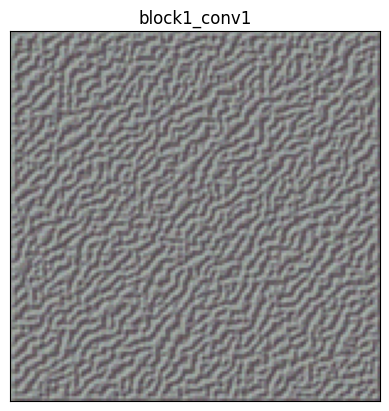

In [11]:
show_one_filter(model, 'block1_conv1', 0, size=150, filename='block1_conv1-filter-0')

layer_output <KerasTensor shape=(None, None, None, 64), dtype=float32, sparse=False, ragged=False, name=keras_tensor_20>
model_input <KerasTensor shape=(None, None, None, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor_19>
loss tf.Tensor(3.5033374, shape=(), dtype=float32)
loss tf.Tensor(4.126568, shape=(), dtype=float32)
loss tf.Tensor(4.840695, shape=(), dtype=float32)
loss tf.Tensor(5.630328, shape=(), dtype=float32)
loss tf.Tensor(6.4851446, shape=(), dtype=float32)
loss tf.Tensor(7.3900695, shape=(), dtype=float32)
loss tf.Tensor(8.339513, shape=(), dtype=float32)
loss tf.Tensor(9.323753, shape=(), dtype=float32)
loss tf.Tensor(10.337148, shape=(), dtype=float32)
loss tf.Tensor(11.377393, shape=(), dtype=float32)
loss tf.Tensor(12.441579, shape=(), dtype=float32)
loss tf.Tensor(13.527945, shape=(), dtype=float32)
loss tf.Tensor(14.633026, shape=(), dtype=float32)
loss tf.Tensor(15.755298, shape=(), dtype=float32)
loss tf.Tensor(16.891483, shape=(), dtype=float32)


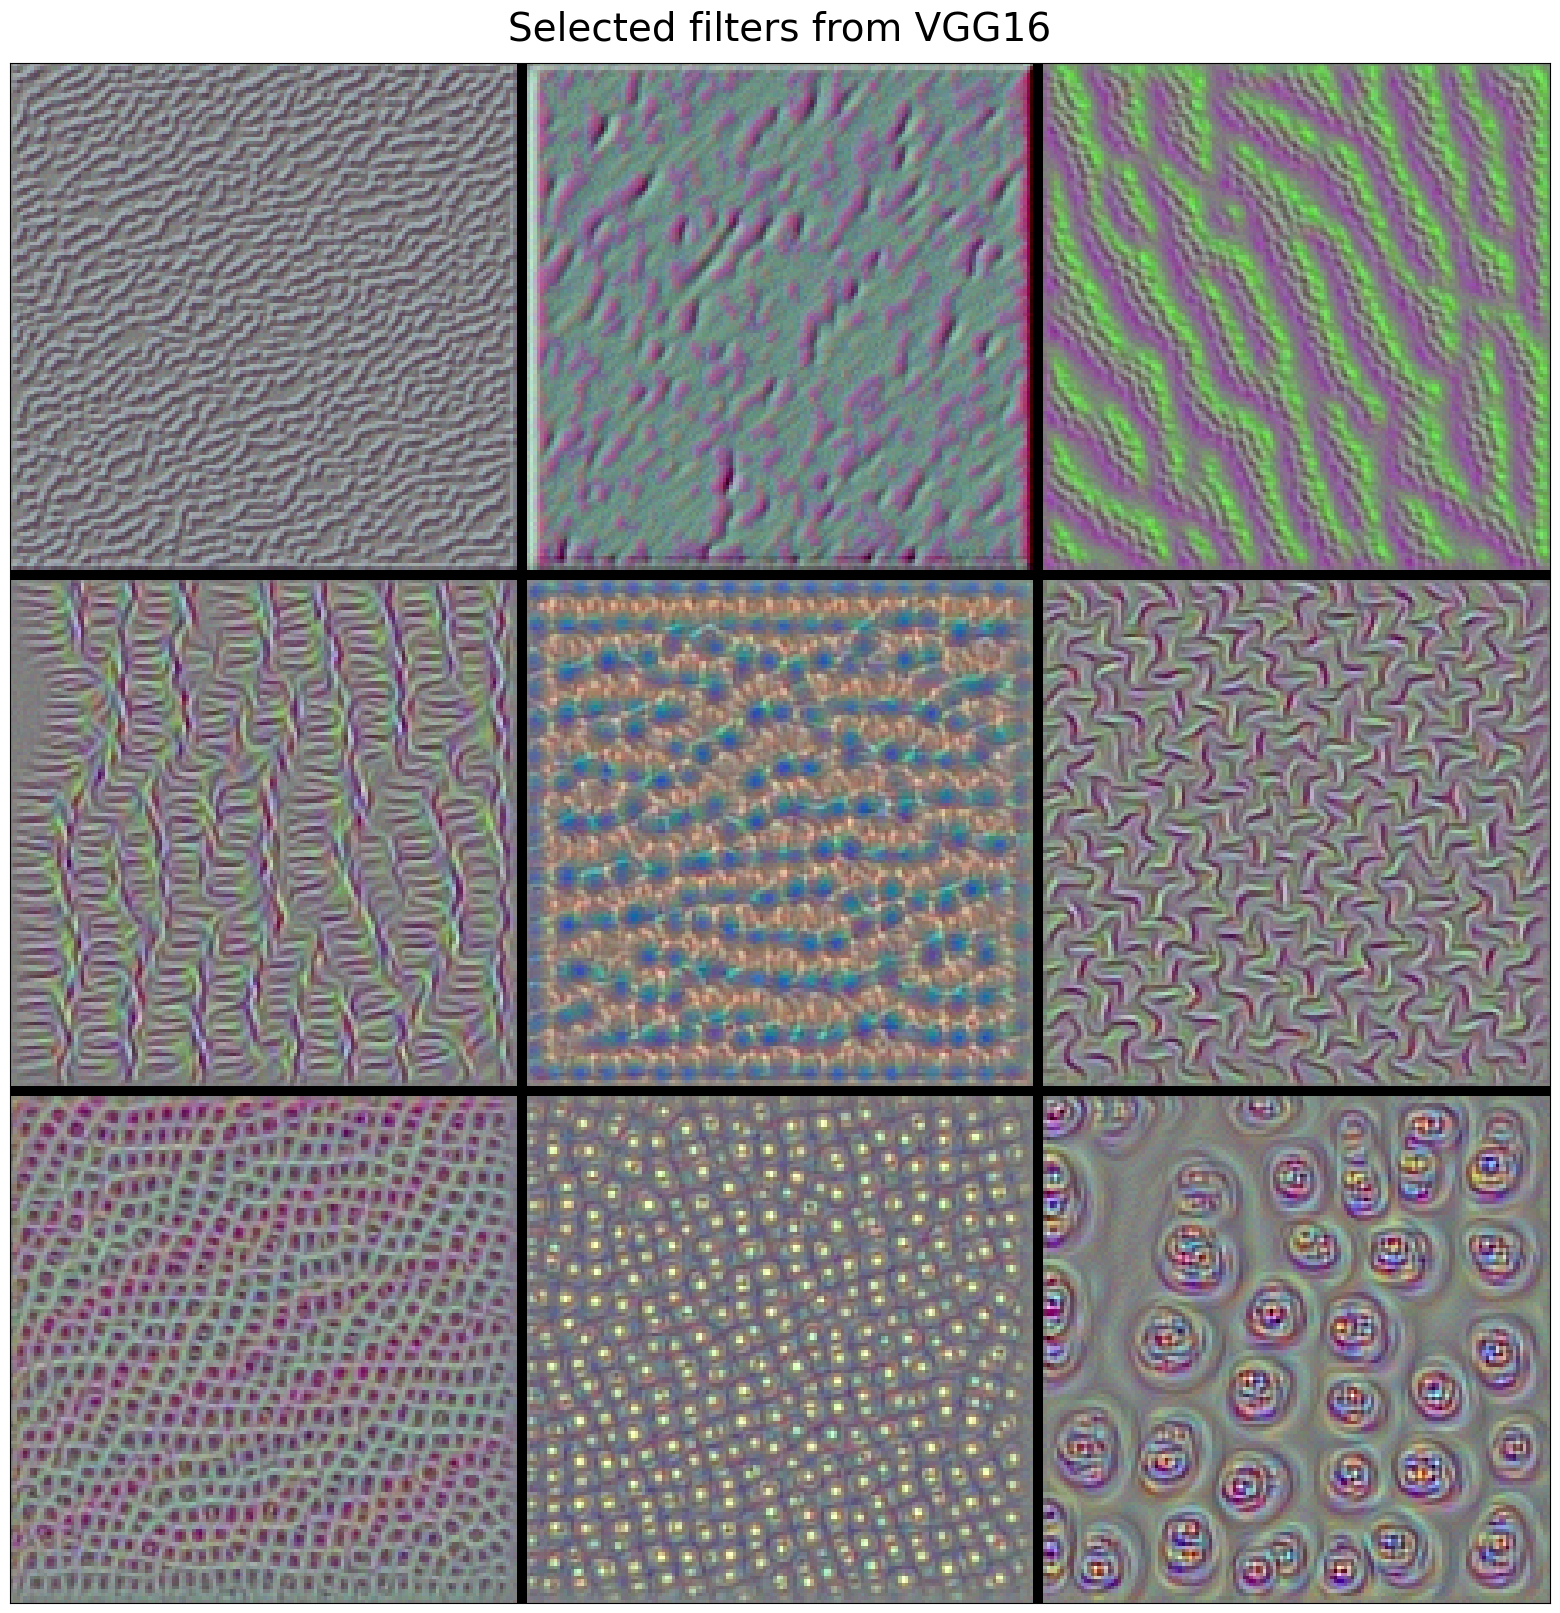

In [17]:
layer_filter_list_1 = [
    ['block1_conv1', 21],
    ['block1_conv2', 12],
    ['block2_conv2', 29],
    ['block3_conv1', 17],
    ['block3_conv1', 28],
    ['block3_conv1', 59],
    ['block3_conv2', 5],
    ['block3_conv2', 8],
    ['block3_conv3', 20]
]

show_selections_grid(model, layer_filter_list_1, 3, 3, filename='VGG16-selections-1')

layer_output <KerasTensor shape=(None, None, None, 256), dtype=float32, sparse=False, ragged=False, name=keras_tensor_28>
model_input <KerasTensor shape=(None, None, None, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor_19>
loss tf.Tensor(361.50018, shape=(), dtype=float32)
loss tf.Tensor(782.0133, shape=(), dtype=float32)
loss tf.Tensor(972.2459, shape=(), dtype=float32)
loss tf.Tensor(1174.0487, shape=(), dtype=float32)
loss tf.Tensor(1372.3306, shape=(), dtype=float32)
loss tf.Tensor(1572.9915, shape=(), dtype=float32)
loss tf.Tensor(1773.7039, shape=(), dtype=float32)
loss tf.Tensor(1975.9938, shape=(), dtype=float32)
loss tf.Tensor(2178.999, shape=(), dtype=float32)
loss tf.Tensor(2384.5312, shape=(), dtype=float32)
loss tf.Tensor(2590.7869, shape=(), dtype=float32)
loss tf.Tensor(2796.6213, shape=(), dtype=float32)
loss tf.Tensor(3008.3916, shape=(), dtype=float32)
loss tf.Tensor(3217.914, shape=(), dtype=float32)
loss tf.Tensor(3432.117, shape=(), dtype=float32)

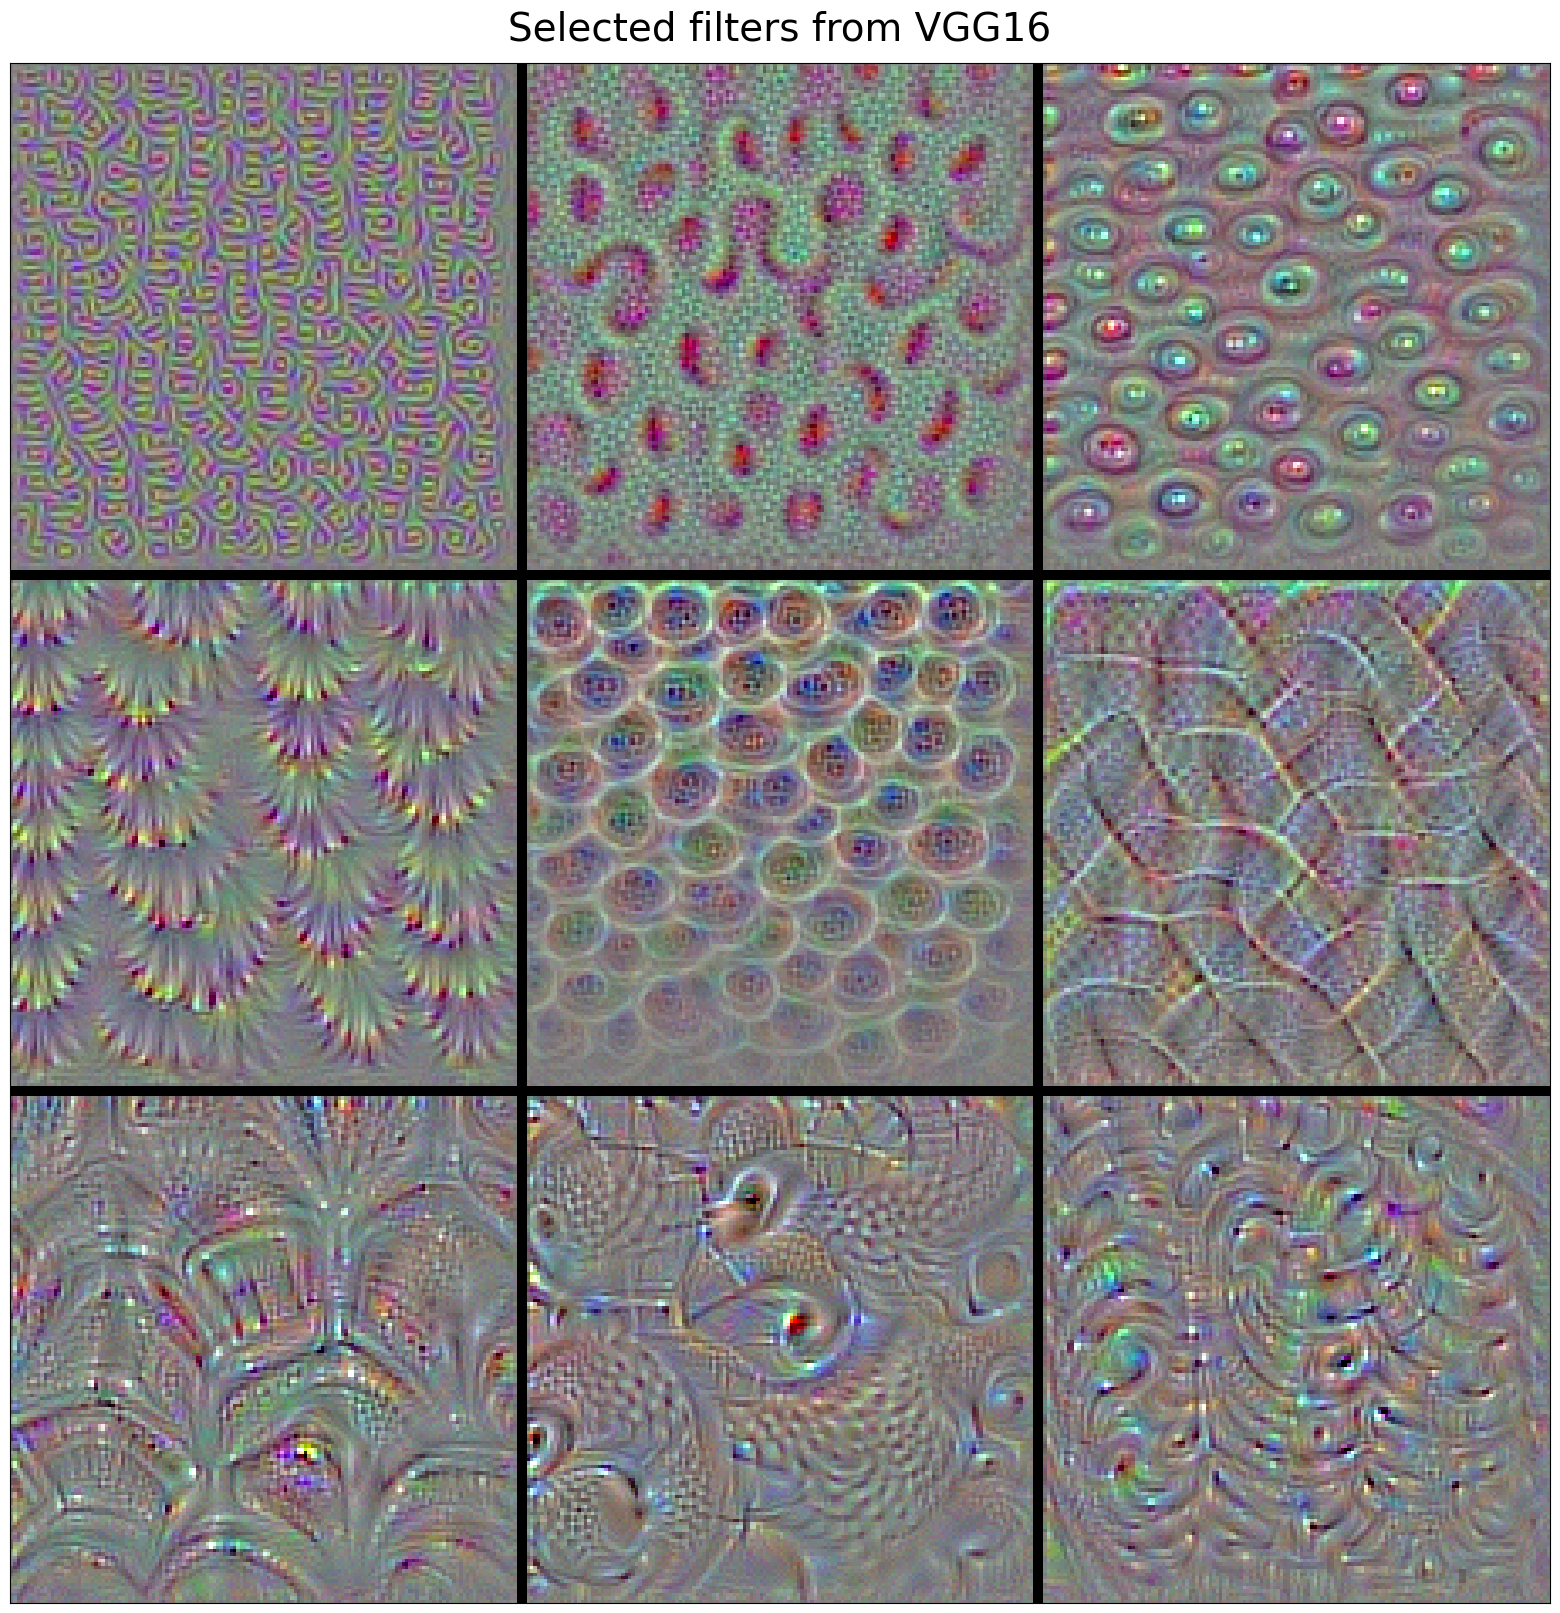

In [19]:
layer_filter_list_2 = [
    ['block3_conv3', 21],
    ['block4_conv1', 0],
    ['block4_conv1', 17],
    ['block4_conv1', 53],
    ['block4_conv1', 47],
    ['block4_conv2', 27],
    ['block5_conv1', 48],
    ['block5_conv2', 25],
    ['block5_conv2', 57]
]

show_selections_grid(model, layer_filter_list_2, 3, 3, filename='VGG16-selections-2')